In [51]:
## Import
from __future__ import print_function
from utils.dataset import BasicDataset
from utils.patient import Patient
import torch
from torch.utils.data import DataLoader
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from unet.unet_model import UNet
import numpy as np
import matplotlib.pyplot as plt
import time
from utils.model_eval import dice_coefficient
import glob


In [2]:
def bool_to_float(v):
    if v == True:
        return 1
    elif v == False:
        return 0
    else:
        return v

In [3]:
## Define Dataset

imgpath = "/Data/ContijochLab/projects/autoseg/train/img/"
segpath = "/Data/ContijochLab/projects/autoseg/train/seg/"

dataset = BasicDataset(imgpath,segpath,data_device='cuda' if torch.cuda.is_available() else 'cpu')

print(dataset)


BasicDataset with 45 items. Image dim: 512x512. Num channels: 1. Device: cuda. 


In [4]:
## Define Data Loader
batch_size = 5
loader = DataLoader(dataset,batch_size = batch_size)


In [5]:
## Parameters
n_channels = 1
n_classes = dataset.__nclass__()
lr = 0.001
wd = 1e-8
mm = 0.9
ep = 100


In [6]:
## Define Net
net = UNet(n_channels=n_channels, n_classes=n_classes+1)
net.to(device=dataset.dev)


UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, moment

In [7]:
## Set up Optimizer

optimizer = optim.RMSprop(net.parameters(),lr = lr, weight_decay = wd, momentum = mm)
critereon = nn.CrossEntropyLoss()    


In [8]:
## Train or Load

loadnet = True

if not loadnet:

    for epoch in range(ep):
        net.train()
        epoch_loss = 0
        for batch in loader:
            imgs = batch['img']
            segs_gt = batch['seg']

            imgs = imgs.to(device=dataset.dev, dtype=torch.float32)
            segs_gt = segs_gt.to(device=dataset.dev, dtype = torch.long)

            segs_pr = net(imgs)

            loss = critereon(segs_pr,segs_gt)
            epoch_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_value_(net.parameters(),0.1)
            optimizer.step()

            print(str(loss))
else:
    loadfile = "/Experiment/unet-save.pth"
    net.load_state_dict(torch.load(loadfile, map_location=dataset.dev))


In [ ]:
## Save Net
savefile = "/Experiment/unet-save.pth"
torch.save(net.state_dict(),savefile)

In [ ]:
## Probability maps
net.eval()

testloader = DataLoader(dataset,batch_size=1)

for testbatch in testloader:
    testimgs, testsegs_gt = testbatch['img'],testbatch['seg']
    
    with torch.no_grad():
        testsegs_pr = net(testimgs)
    testsegs_pr = torch.softmax(testsegs_pr,dim=1)
    _,testsegs_cl = torch.max(testsegs_pr,dim=1)
    testsegs_pr = testsegs_pr.to(device='cpu')
    testsegs_cl = testsegs_cl.to(device='cpu')
    fig1,ax1 = plt.subplots(3,4)
    fig1.set_figwidth(20)
    fig1.set_figheight(14)
    for axInd in range(n_classes):        
        if axInd < 4:
            ax1[0,axInd%4].imshow(testsegs_pr[0,axInd+1,:,:].numpy(),vmin = 0, vmax = 1)
        elif axInd < 8:
            ax1[1,axInd%4].imshow(testsegs_pr[0,axInd+1,:,:].numpy(),vmin = 0, vmax = 1)
        else:
            ax1[2,axInd%4].imshow(testsegs_pr[0,axInd+1,:,:].numpy(),vmin = 0, vmax = 1)
            
    fig2,ax2 = plt.subplots(3,4)
    fig2.set_figwidth(20)
    fig2.set_figheight(14)
    for axInd in range(n_classes):
#         X = (testsegs_cl[0,:,:].numpy()>(axInd+1-0.1) & testsegs_cl[0,:,:].numpy()<(axInd+1+0.1))
        X = testsegs_cl[0,:,:].numpy() == (axInd+1)
        X = X.astype(np.float)
        if axInd < 4:
            ax2[0,axInd%4].imshow(X,vmin = 0, vmax = 1)
        elif axInd < 8:
            ax2[1,axInd%4].imshow(X,vmin = 0, vmax = 1)
        else:
            ax2[2,axInd%4].imshow(X,vmin = 0, vmax = 1)

        

Median[0.99826125 0.99124113 0.         0.91050136 0.81420763 0.90394211
 0.71906565 0.83510947 0.96333694 0.         0.92380952 0.92979904]
IQR   [0.00084996 0.00665506 0.         0.06804178 0.1754241  0.05208071
 0.12282339 0.03006508 0.01151827 0.         0.01425026 0.05244804]


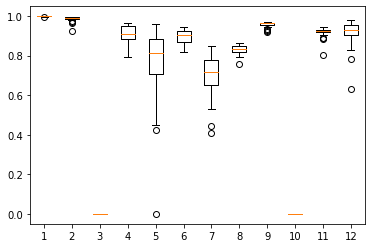

In [33]:
## Test Net on Training Data

net.eval()

testloader = DataLoader(dataset,batch_size=1)

imInd = 0

dc = np.zeros((n_classes,45))

for testbatch in testloader:
    
    testimgs, testsegs_gt = testbatch['img'],testbatch['seg']
    
    with torch.no_grad():
        testsegs_pr = net(testimgs)
    
    test_segs_pr = torch.softmax(testsegs_pr,dim=1)
    _,testsegs_cl = torch.max(testsegs_pr,dim=1)
    
    testimgs = testimgs.to(device='cpu')
    testsegs_gt = testsegs_gt.to(device='cpu')
    testsegs_cl = testsegs_cl.to(device='cpu')
    
    for lblInd in range(n_classes):
        dcval = dice_coefficient(testsegs_gt, testsegs_cl, lblInd+1)
        dc[lblInd,imInd] = dcval
#         print(str(lblInd) + ": " + str(dcval))
    
    imInd += 1

figb,axb = plt.subplots()
axb.boxplot(np.transpose(dc))
# print(dc)
q1 = np.percentile(dc, 25,axis=1)
q2 = np.percentile(dc, 50,axis=1)
q3 = np.percentile(dc, 75,axis=1)
print("Median" + str(q2))
print("IQR   " + str(q3-q1))


In [59]:
## Predict

predict_path = "/Data/ContijochLab/projects/autoseg/predict"

for filename in glob.glob(predict_path+"/CTCAC*"):
    print(filename)
    fnspl = filename.split("/")
    if not os.path.exists(filename + "/s04-nii"):
        os.mkdir(filename + "/s04-nii")
    patfile = filename + "/img-nii/" + fnspl[-1] + ".nii.gz"
    segfile = filename + "/s04-nii/" + fnspl[-1] + ".nii.gz"
    
    patient = Patient(patfile,data_device='cuda' if torch.cuda.is_available() else 'cpu')

    patient.predict(net,segfile,batch_size=5)

/Data/ContijochLab/projects/autoseg/predict/CTCAC1901281601
[0 1 2 3 4]
[5 6 7 8 9]
[10 11 12 13 14]
[15 16 17 18 19]
[20 21 22 23 24]
[25 26 27 28 29]
[30 31 32 33 34]
[35 36 37 38 39]
[40 41 42 43 44]
[45 46 47 48 49]
[50 51 52 53 54]
[55]
/Data/ContijochLab/projects/autoseg/predict/CTCAC1901281608
[0 1 2 3 4]
[5 6 7 8 9]
[10 11 12 13 14]
[15 16 17 18 19]
[20 21 22 23 24]
[25 26 27 28 29]
[30 31 32 33 34]
[35 36 37 38 39]
[40 41 42 43 44]
[45 46 47 48 49]
[50 51 52 53 54]
[55 56 57 58 59]
[60 61 62 63]
/Data/ContijochLab/projects/autoseg/predict/CTCAC1903181826
[0 1 2 3 4]
[5 6 7 8 9]
[10 11 12 13 14]
[15 16 17 18 19]
[20 21 22 23 24]
[25 26 27 28 29]
[30 31 32 33 34]
[35 36 37 38 39]
[40 41 42 43 44]
[45 46 47 48 49]
[50 51 52 53 54]
[55 56 57 58 59]
[60 61 62 63]
/Data/ContijochLab/projects/autoseg/predict/CTCAC1906061647
[0 1 2 3 4]
[5 6 7 8 9]
[10 11 12 13 14]
[15 16 17 18 19]
[20 21 22 23 24]
[25 26 27 28 29]
[30 31 32 33 34]
[35 36 37 38 39]
[40 41 42 43 44]
[45 46 47 48 49]
[5

In [11]:
## Load Patient and Predict

predict_path = "/Data/ContijochLab/projects/autoseg/predict/"




# pat_file = "/Data/ContijochLab/projects/autoseg/predict/CTCAC1901281601/img-nii/CTCAC1901281601.nii.gz"
# seg_file = "/Data/ContijochLab/projects/autoseg/predict/CTCAC1901281601/s04-nii/CTCAC1901281601.nii.gz"

# pat_file = "/Data/ContijochLab/projects/autoseg/predict/CTCAC1901281608/img-nii/CTCAC1901281608.nii.gz"
# seg_file = "/Data/ContijochLab/projects/autoseg/predict/CTCAC1901281608/s04-nii/CTCAC1901281608.nii.gz"

# pat_file = "/Data/ContijochLab/projects/autoseg/predict/CTCAC1903181826/img-nii/CTCAC1903181826.nii.gz"
# seg_file = "/Data/ContijochLab/projects/autoseg/predict/CTCAC1903181826/s04-nii/CTCAC1903181826.nii.gz"

# pat_file = "/Data/ContijochLab/projects/autoseg/predict/CTCAC1906061647/img-nii/CTCAC1906061647.nii.gz"
# seg_file = "/Data/ContijochLab/projects/autoseg/predict/CTCAC1906061647/s04-nii/CTCAC1906061647.nii.gz"

# pat_file = "/Data/ContijochLab/projects/autoseg/predict/CTCAC1906071329/img-nii/CTCAC1906071329.nii.gz"
# seg_file = "/Data/ContijochLab/projects/autoseg/predict/CTCAC1906071329/s04-nii/CTCAC1906071329.nii.gz"

pat_file = "/Data/ContijochLab/projects/autoseg/predict/CTCAC1906071741/img-nii/CTCAC1906071741.nii.gz"
seg_file = "/Data/ContijochLab/projects/autoseg/predict/CTCAC1906071741/s04-nii/CTCAC1906071741.nii.gz"

patient = Patient(pat_file,data_device='cuda' if torch.cuda.is_available() else 'cpu')

patient.predict(net,seg_file,batch_size=5)

[0 1 2 3 4]
[5 6 7 8 9]
[10 11 12 13 14]
[15 16 17 18 19]
[20 21 22 23 24]
[25 26 27 28 29]
[30 31 32 33 34]
[35 36 37 38 39]
[40 41 42 43 44]
[45 46 47 48 49]
[50 51 52 53 54]
[55 56 57 58 59]
[60 61 62 63]


In [ ]:
float(True)